# Проект: Исследовательский анализ данных для Яндекс Афиши, проверка гипотез. .

- Автор: Петухова О.А.
- Дата: 15.07.2025

## Введение

### Цели и задачи проекта

**Цель** - провести исследовательский анализ данных, чтобы ответить на вопросы коллег.


**Задачи:**
1. выявить инсайты об изменении пользовательских предпочтений;
2. какие события стали привлекать больше зрителей;
3. какие организаторы и площадки стали лидерами;
4. проверить гипотезы о разнице в поведении пользователей с мобильными и стационарными устройствами.

### Содержание проекта
1. Загрузка данных и знакомство с ними.
2. Предобработка данных и подготовка их к исследованию.
3. Исследовательский анализ данных. Распределения заказов по сегментам и их сезонные изменения.
   - 3.1 Анализ распределения заказов по сегментам и их сезонные изменения.
   - 3.2 Осенняя активность пользователей.
   - 3.3 Популярные события и партнеры.
4. Статистический анализ данных.
5. Общий вывод и рекомендации.

### 1. Загрузка данных и знакомство с ними.

Загрузим библиотеки и датасеты.


In [2]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from scipy.stats import mannwhitneyu


In [5]:
# Выгрузим данные в переменные orders_df, events_df.
orders_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv')
events_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')
tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [8]:
orders_df.sample(n=5)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
177102,4666681,90ada8e6d56bd6b,2024-09-08,2024-09-08 14:57:53,393570,нет,6,rub,mobile,180.02,Лучшие билеты,3,4500.51,11.0
135463,3239417,6cf5aff356429e5,2024-07-22,2024-07-22 12:02:31,546167,нет,0,rub,desktop,5.33,Билеты без проблем,2,133.16,0.0
210671,4961843,b0076384887de2a,2024-06-05,2024-06-05 09:32:50,530997,нет,6,rub,mobile,185.22,Весь в билетах,2,1322.98,0.0
228841,2812508,c2e3afcac39c500,2024-10-18,2024-10-18 12:56:16,516838,нет,18,rub,mobile,556.38,Тебе билет!,4,5563.76,0.0
204955,5285889,acddb815a4ad10e,2024-10-03,2024-10-03 10:03:30,383566,нет,18,rub,mobile,398.97,Облачко,2,3069.00,2.0


In [10]:
orders_df.info()
orders_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

(290849, 14)

Датасет `orders_df` содержит 14 столбцов и 290849 строк.

После первичного анализа данных можно сделать следующие выводы:

- Значения в столбцах `order_id`, `event_id`, `age_limit`, `tickets_count` представлены типом данных int. У `age_limit` и `tickets_count` можно снизить размерность.
- Столбцы `user_id`, `cinema_circuit`, `currency_code`, `device_type_canonical`, `service_name`, `created_dt_msk`, `created_ts_msk` представлен уникальным типом данных object, столбцы `created_dt_msk`, `created_ts_msk` следует привести к datetime. `Cinema_circuit`, `age_limit`, `currency_code`, `device_type_canonical`, `service_name` отнести к типу данных category.
- Cтолбец `revenue`, `total`, `days_since_prev` - тип данных float.
- Пропусков в столбцах нет, кроме `days_since_prev`. Загрузка с SQL прошла успешно.
- Все столбцы приведены к единому виду snake case.

In [14]:
# Приведем данные к оптимальным типам данных.
orders_df['age_limit'] = pd.to_numeric(orders_df['age_limit'], downcast = 'integer')
orders_df['tickets_count'] = pd.to_numeric(orders_df['tickets_count'], downcast = 'integer')
orders_df['created_dt_msk'] = pd.to_datetime(orders_df['created_dt_msk'])
orders_df['created_ts_msk'] = pd.to_datetime(orders_df['created_ts_msk'])
orders_df[['cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical', 'service_name']] = orders_df[['cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical', 'service_name']].astype('category')

In [16]:
print(f'Представлены следующие сети кинотеатров:')
display(orders_df['cinema_circuit'].value_counts())
print(f'Возрастные ограничения:')
display(orders_df['age_limit'].value_counts())
print(f'Валюта оплаты:')
display(orders_df['currency_code'].value_counts())
print(f'Типы устройств:')
display(orders_df['device_type_canonical'].value_counts())
print(f'Билетные операторы:')
display(orders_df['service_name'].value_counts())

Представлены следующие сети кинотеатров:


нет           289451
Другое          1261
КиноСити         122
Киномакс           7
Москино            7
ЦентрФильм         1
Name: cinema_circuit, dtype: int64

Возрастные ограничения:


16    78579
12    62557
0     61487
6     52173
18    36053
Name: age_limit, dtype: int64

Валюта оплаты:


rub    285780
kzt      5069
Name: currency_code, dtype: int64

Типы устройств:


mobile     232679
desktop     58170
Name: device_type_canonical, dtype: int64

Билетные операторы:


Билеты без проблем        63709
Лови билет!               41126
Билеты в руки             40364
Мой билет                 34843
Облачко                   26642
Лучшие билеты             17795
Весь в билетах            16849
Прачечная                 10273
Край билетов               6207
Тебе билет!                5228
Яблоко                     5039
Дом культуры               4502
За билетом!                2865
Городской дом культуры     2733
Show_ticket                2200
Мир касс                   2167
Быстробилет                2003
Выступления.ру             1616
Восьмёрка                  1118
Crazy ticket!               790
Росбилет                    539
Шоу начинается!             499
Быстрый кассир              381
Радио ticket                376
Телебилет                   321
КарандашРУ                  133
Реестр                      125
Билет по телефону            85
Вперёд!                      80
Дырокол                      74
Кино билет                   67
Цвет и б

В данных сети кинотеатров 289451 строк со значением - 'нет'. Без возрастных ограничений 61487 строк.

Данные хорошего качества, пропуски содержатся только в столбце days_since_prev, но это нормально, так как он содержит количество дней с предыдущей покупки каждого пользователя, а повторную покупку могли не совершать. Также некоторые столбцы приведены к правильному типу данных и снижена размерность.  Данных по сети кинотеатров практически нет, может это связано с тем, исключили фильмы. В категориальных данных нет аномалий. 

In [23]:
events_df.sample(n=5)

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
103,10914,20be7743-67f2-4ffc-88e3-4486ee3c2829,спектакль,театр,№1037,Горицветская область,Островецк,50,3896,"Заповедник ""Ода"" и партнеры","ул. Ленская, д. 1/6 к. 2"
7083,420836,939507bd-23ec-4307-b6a5-8247921f86f6,спортивное мероприятие,спорт,№1550,Каменевский регион,Глиногорск,213,1616,"Центр по изучению культуры ""Огни"" Групп","бул. Большой, д. 5/7 стр. 1"
8440,470116,ddcb9000-7e2e-4005-a0c3-518aea8262b1,спектакль,театр,№3568,Солнечноземская область,Глинополье,56,3878,"Студия дизайна ""Ритмы"" и партнеры","пер. 8 Марта, д. 492 стр. 479"
11187,522404,690a39c8-dc2b-4fee-b88c-e56da49df59a,событие,другое,№3498,Серебринская область,Озёрчане,62,4334,"Творческая инициатива ""Платформа"" и партнеры","ш. Панфилова, д. 10 к. 9"
161,11333,856c96ad-5ffa-41f6-9163-65e136b9e586,опера,театр,№5024,Североярская область,Озёрск,2,2937,"Лаборатория по созданию комиксов ""Стоимость"" Г...","ул. Волочаевская, д. 44"


In [25]:
events_df.info()
events_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


(22427, 11)

Датасет `events_df` содержит 11 столбцов и 22427 строк.

После первичного анализа данных можно сделать следующие выводы:

- Значения в столбцах `event_id`, `city_id`, `venue_id` представлены типом данных int.
- Столбцы `event_name`, `event_type_description`, `event_type_main`, `organizers`, `region_name`, `city_name`, `venue_name`, `venue_address` представлен уникальным типом данных object. `Event_type_main`, `organizers` следует привести к типу данных category.
- Пропусков в столбцах нет.
- Названия столбцов приведены к единому виду snake case.

In [28]:
# Приводим столбцы к правильному типу данных.
events_df[['event_type_main', 'organizers']] = events_df[['event_type_main', 'organizers']].astype('category')

In [30]:
print(f'Представлены следующие типы мероприятий:')
display(events_df['event_type_main'].value_counts())
print(f'Организаторы:')
display(events_df['organizers'].value_counts())
print(f'Регионы:')
display(events_df['region_name'].value_counts())


Представлены следующие типы мероприятий:


концерты    8680
театр       7076
другое      4658
спорт        872
стендап      636
выставки     290
ёлки         215
Name: event_type_main, dtype: int64

Организаторы:


№1874    121
№1659    120
№1738    117
№5024    117
№3529    113
        ... 
№2100      1
№2101      1
№3553      1
№2105      1
№3146      1
Name: organizers, Length: 4293, dtype: int64

Регионы:


Каменевский регион          5983
Североярская область        3814
Широковская область         1233
Светополянский округ        1075
Речиновская область          702
                            ... 
Верхозёрский край              2
Теплоозёрский округ            2
Сосноводолинская область       2
Светолесский край              2
Лесноярский край               2
Name: region_name, Length: 81, dtype: int64

Данные в датафейме events_df также выгрузились корректно, пропусков не содержит, были неправильные типы данных у столбцов - исправили. Категориальные данные без аномалий.

In [33]:
tenge_df.sample(n=5)

,data,nominal,curs,cdx
12,2024-01-22,100,19.6081,kzt
205,2024-08-02,100,18.0997,kzt
303,2024-11-08,100,19.9278,kzt
9,2024-01-19,100,19.5741,kzt
192,2024-07-20,100,18.4518,kzt


In [35]:
tenge_df.info()
tenge_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


(357, 4)

In [37]:
tenge_df['data'] = pd.to_datetime(tenge_df['data'])

Объеденим датафреймы.

In [40]:
df1 = orders_df.merge(events_df, how = 'left', on = 'event_id')
df= df1.merge(tenge_df, how = 'left', left_on = 'created_dt_msk', right_on = 'data')

In [43]:
#Отфильтруем по интересующим датам
start_date = '2024-06-01'
end_date = '2024-10-31'

df = df[(df['created_dt_msk'] >= start_date) & (df['created_dt_msk'] <= end_date)]

In [45]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290849 entries, 0 to 290848
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290849 non-null  int64         
 1   user_id                 290849 non-null  object        
 2   created_dt_msk          290849 non-null  datetime64[ns]
 3   created_ts_msk          290849 non-null  datetime64[ns]
 4   event_id                290849 non-null  int64         
 5   cinema_circuit          290849 non-null  category      
 6   age_limit               290849 non-null  category      
 7   currency_code           290849 non-null  category      
 8   device_type_canonical   290849 non-null  category      
 9   revenue                 290849 non-null  float64       
 10  service_name            290849 non-null  category      
 11  tickets_count           290849 non-null  int8          
 12  total                   290849

(290849, 28)

In [47]:
# Подсчитываем процент строк с пропусками
df.isna().sum() / len(df) * 100

order_id                  0.000000
user_id                   0.000000
created_dt_msk            0.000000
created_ts_msk            0.000000
event_id                  0.000000
cinema_circuit            0.000000
age_limit                 0.000000
currency_code             0.000000
device_type_canonical     0.000000
revenue                   0.000000
service_name              0.000000
tickets_count             0.000000
total                     0.000000
days_since_prev           7.543433
event_name                0.081829
event_type_description    0.081829
event_type_main           0.081829
organizers                0.081829
region_name               0.081829
city_name                 0.081829
city_id                   0.081829
venue_id                  0.081829
venue_name                0.081829
venue_address             0.081829
data                      0.000000
nominal                   0.000000
curs                      0.000000
cdx                       0.000000
dtype: float64

В столбцах event_name, event_type_description, event_type_main, organizers, region_name, city_name, city_id, venue_id, venue_name, venue_address небольшое количество пропусков 0.08 процентов, их можно удалить. Столбец `day_since_prev`  дополнительный, там могут оставаться пропуски, поэтому оставим без изменений.

In [50]:
df2 = df.dropna(subset=['event_name', 'event_type_description', 'event_type_main', 'organizers', 'region_name', 'city_name', 'city_id', 'venue_id', 'venue_name', 'venue_address'])

In [53]:
# Посмотрим, если ли выбросы в столбце выручка с заказа.
group_currency = df2.groupby('currency_code').agg(mean_tickets=('tickets_count', 'mean'), median_tickets=('tickets_count', 'median'), mean_revenue=('revenue', 'mean'), median_revenue=('revenue', 'median')).reset_index()
group_currency

,currency_code,mean_tickets,median_tickets,mean_revenue,median_revenue
0,kzt,2.762872,3,4995.206767,3698.83
1,rub,2.754159,3,548.013929,346.63


Выбросов в количестве заказов в билете не наблюдается, а вот среднее и медиана по выручке отличается, похоже, что в данных есть выбросы. 

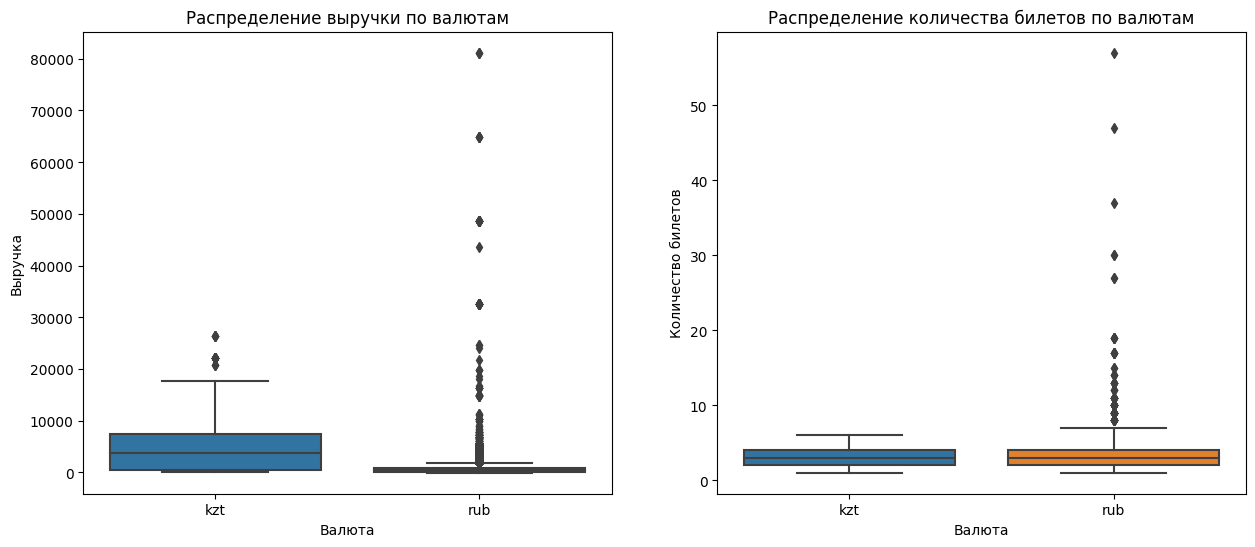

In [56]:
# Создадим диаграму размаха для выручки (revenue) по валютам
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df2, x='currency_code', y='revenue')
plt.title('Распределение выручки по валютам')
plt.ylabel('Выручка')
plt.xlabel('Валюта')

# Создадим диаграмму размаха для количества билетов (tickets_count) по валютам
plt.subplot(1, 2, 2)
sns.boxplot(data=df2, x='currency_code', y='tickets_count')
plt.title('Распределение количества билетов по валютам')
plt.ylabel('Количество билетов')
plt.xlabel('Валюта')
plt.show()

Опасения подтвердились, данные по выручке нужно будет отфильтровать.

In [59]:
#Посмотрим полные дубликаты
df2.duplicated().sum()

0

In [62]:
#Посмотрим неявные дубликаты, по условия проекта, нам нужно рассмотреть все столбцы, кроме order_id.
duplicates = df2.drop(columns='order_id').duplicated(keep=False).sum()
percent_duplicate = round(duplicates / df2.shape[0] * 100, 2)
print (f' Найдено дубликатов: {duplicates}')
print (f' Всего строк в датафрейме до удаления дубликатов: {df2.shape[0]}')
print (f' Процент дубликатов от общего количества строк: {percent_duplicate}%')

 Найдено дубликатов: 58
 Всего строк в датафрейме до удаления дубликатов: 290611
 Процент дубликатов от общего количества строк: 0.02%


Достаточно небольшое количество дубликатов (0.02%). Удалим их.

In [65]:
new_df_cleaned = df2.drop_duplicates(subset=df2.drop(columns='order_id').columns, keep='first')
print (f' Всего строк в датафрейме после удаления дубликатов: {new_df_cleaned.shape[0]} строк.')

 Всего строк в датафрейме после удаления дубликатов: 290581 строк.


In [67]:
#Приведем выручку с заказа к единой валюте, для этого создадим новый столбец revenue_rub.
new_df_cleaned = new_df_cleaned.copy()
new_df_cleaned['revenue_rub']=new_df_cleaned[new_df_cleaned['currency_code']=='kzt']['revenue']*(new_df_cleaned['curs']/100)
rub_mask = new_df_cleaned['currency_code']=='rub'
new_df_cleaned.loc[rub_mask, 'revenue_rub']=new_df_cleaned.loc[rub_mask, 'revenue']
new_df_cleaned.sample(n=5)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,city_name,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx,revenue_rub
276251,4283707,f312ae2133408be,2024-09-21,2024-09-21 15:48:16,512269,нет,16,rub,mobile,628.30,...,Теплоозеро,38.0,1124.0,"Школа живописи ""Проблема"" и партнеры","ш. Красное, д. 819 стр. 30",2024-09-21,100,19.3316,kzt,628.30
145697,5796898,77eba1002a839ca,2024-10-16,2024-10-16 11:06:58,583930,нет,18,rub,mobile,5198.01,...,Глиногорск,213.0,4363.0,"Студия дизайна ""Лестница"" Лимитед","наб. Школьная, д. 9/8 стр. 7/5",2024-10-16,100,20.0393,kzt,5198.01
228555,2768167,c2c6d35ff678ca6,2024-08-06,2024-08-06 13:26:42,379268,нет,0,rub,mobile,108.77,...,Озёрск,2.0,1283.0,"Клуб начинающих писателей ""Детство"" Лимитед","ул. Заозерная, д. 9",2024-08-06,100,17.8998,kzt,108.77
1329,2026521,019fa401ddb00aa,2024-10-11,2024-10-11 22:23:40,209631,нет,12,rub,mobile,33.76,...,Глиногорь,10951.0,3012.0,"Творческая ассоциация ""Фазенда"" Лимитед","ул. Мостовая, д. 93 к. 9",2024-10-11,100,19.8829,kzt,33.76
93764,1759373,44c1c640a242aea,2024-09-17,2024-09-17 15:36:20,403924,нет,18,rub,mobile,704.17,...,Глиногорск,213.0,2189.0,"Искусственная сцена ""Тепло"" Лимитед","ул. Овражная, д. 5 стр. 210",2024-09-17,100,19.0125,kzt,704.17


Теперь, когда мы привели выручку к единой валюте, уберем из данных выбросы.

In [70]:
#Уберем выбросы, возьмем 0.01 и 0.99 перцентели.
low_percentile = new_df_cleaned['revenue_rub'].quantile(0.01)
high_percentile = new_df_cleaned['revenue_rub'].quantile(0.99)
print(f"Границы выбросов: нижняя {low_percentile:.2f}, верхняя {high_percentile:.2f}")

#Фильтрация выбросов
new_df_cleaned = new_df_cleaned[(new_df_cleaned['revenue_rub'] >= low_percentile) & (new_df_cleaned['revenue_rub'] <= high_percentile)].copy()
print(new_df_cleaned['revenue_rub'].describe())
print(f' Количество строк после фильтрации и удаления дубликатов: {new_df_cleaned.shape[0]}')

Границы выбросов: нижняя 0.00, верхняя 2628.42
count    287375.000000
mean        518.738402
std         511.956308
min           0.000000
25%         112.640000
50%         344.840000
75%         788.900000
max        2628.421739
Name: revenue_rub, dtype: float64
 Количество строк после фильтрации и удаления дубликатов: 287375


In [73]:
# Создаем столбец с выручкой за один билет в рублях
new_df_cleaned['one_ticket_revenue_rub'] = (new_df_cleaned['revenue_rub'] / new_df_cleaned['tickets_count'])
new_df_cleaned.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,100,18.6972,kzt,1521.94,380.4850
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,100,18.3419,kzt,289.45,144.7250
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,100,19.6475,kzt,1258.57,314.6425
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,100,18.5010,kzt,8.49,4.2450
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,100,19.6648,kzt,1390.41,463.4700


In [75]:
#Создадим отдельный столбец месяц заказа.
new_df_cleaned['month'] = (new_df_cleaned['created_dt_msk']).dt.month


In [77]:
# Функция для определения сезона по месяцу
def categorize (month):
    if 3<= month < 6:
        return "весна"
    elif 6<= month < 9:
        return "лето"
    elif 9<= month <12:
        return "осень"
    else: 
        return "зима"
#Создадим новый столбец с сезонностью
new_df_cleaned['season'] = new_df_cleaned['month'].apply(categorize)
new_df_cleaned.sample(n=5)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,venue_name,venue_address,data,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub,month,season
94174,4958653,44c1c640a242aea,2024-10-05,2024-10-05 21:23:44,570855,нет,12,rub,mobile,2500.17,...,"Академия прикладного искусства ""Птица"" Лтд","алл. Песчаная, д. 677",2024-10-05,100,19.6475,kzt,2500.17,833.390000,10,осень
23251,2499714,0beb8fc0c0a9ce1,2024-10-18,2024-10-18 23:02:56,447949,нет,12,rub,mobile,1773.08,...,"Цирковая студия ""Турнир"" Лтд","наб. Станционная, д. 3/1",2024-10-18,100,19.8697,kzt,1773.08,354.616000,10,осень
177401,938412,9103be7b790235f,2024-06-01,2024-06-01 16:22:16,487683,нет,6,rub,mobile,749.32,...,"Танцевальная школа ""Эксперт"" Лтд","пр. Ольховый, д. 667",2024-06-01,100,20.2773,kzt,749.32,249.773333,6,лето
67512,4827022,2e3e33065c2056f,2024-09-13,2024-09-13 21:24:21,554052,нет,6,rub,mobile,622.18,...,"Школа сценического мастерства ""Вдох"" Лтд","пер. Полярный, д. 87",2024-09-13,100,19.0758,kzt,622.18,155.545000,9,осень
206027,3648056,ad2dc32364ed948,2024-07-20,2024-07-20 18:32:15,501198,нет,0,rub,mobile,35.89,...,"Цирковая студия ""Год"" Инкорпорэйтед","ш. Тракторное, д. 9",2024-07-20,100,18.4518,kzt,35.89,11.963333,7,лето


Поработав с данными мы сделали следующее. 
Приведены данные к правильным типам, снизили размерность. Объединили датафреймы в один, отфильтровав его по дате с 01.06.2024 по 31.10.2024. Удалили пустые строки у основных столбцов. Проверили столбцы tickets_count и revenue на выбросы. Создали столбец revenue_rub, в нем привели выручку к единой валюте, затем отфильтровали от отрицательных и аномально высоких значений. Нашли дубликаты, удалили их. После фильтрации в датафрейме осталось 281674 строк. Создали новый столбец и привели выручку к единой валюте. Создали столбец с выручкой за один билет. Создали столбец для определения сезона. Можно приступить к следующему шагу - исследовательскому анализу данных.

### Исследовательский анализ данных. Распределения заказов по сегментам и их сезонные изменения.

#### 3.1 Анализ распределения заказов по сегментам и их сезонные изменения.

Для каждого месяца найдем количество заказов.

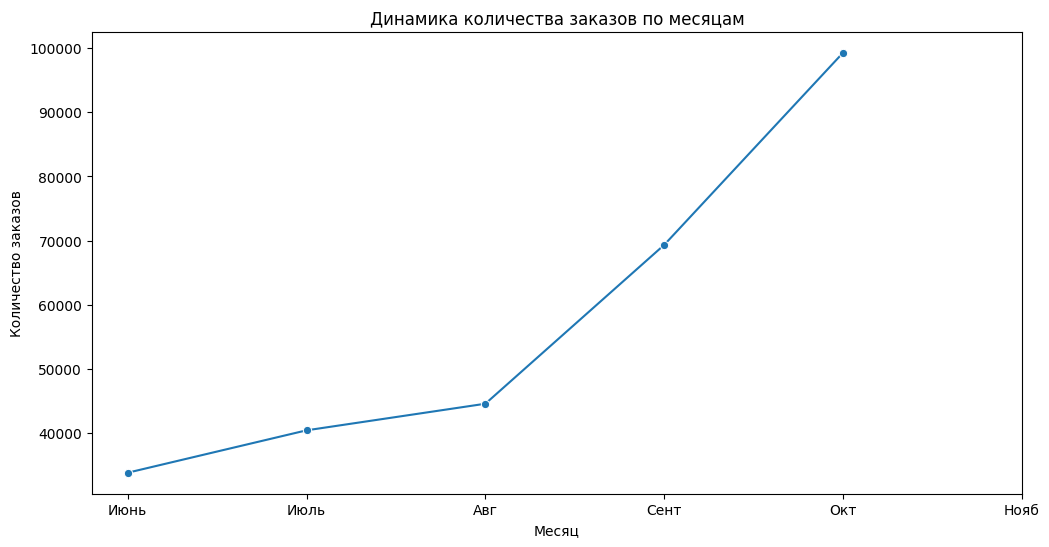

In [86]:
month_order = new_df_cleaned.groupby('month').agg(order_count = ('order_id', 'count')).reset_index()
#Визуализируем
plt.figure(figsize=(12, 6))
sns.lineplot(data=month_order, x='month', y='order_count', marker='o')
plt.title('Динамика количества заказов по месяцам')
plt.xlabel('Месяц')
plt.xticks(ticks=range(6, 12), labels=['Июнь', 'Июль', 'Авг', 'Сент', 'Окт', 'Нояб'])
plt.ylabel('Количество заказов')
plt.show()

По количеству заказов видно, что в первые два летних месяца наблюдался небольшой рост, начиная с августа количество заказов стало в два раза больше.

Для осеннего и летнего периодов сравним распределение заказов билетов по разным категориям: тип мероприятия, тип устройства, категория мероприятия по возрастному рейтингу. 

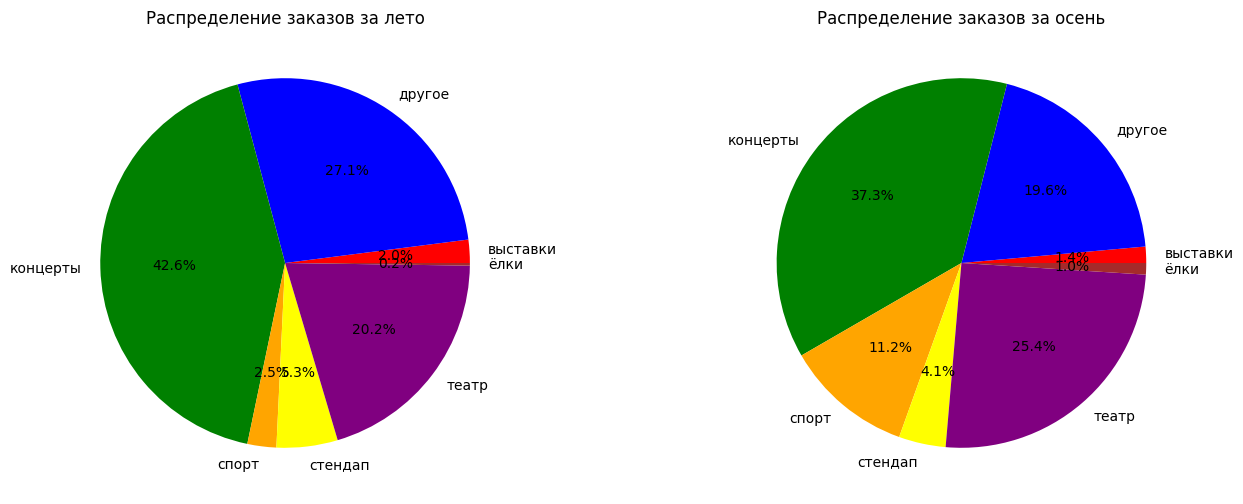

In [90]:
season_summer = new_df_cleaned[new_df_cleaned['season'] == 'лето'].groupby('event_type_main')['order_id'].count()
plt.figure(figsize=(16, 6))
#Диаграмма для летнего периода
plt.subplot(1, 2, 1)
season_summer.plot(
    kind='pie' ,
    title='Распределение заказов за лето',
    autopct='%.1f%%',
    ylabel='' ,
    colors=['red', 'blue', 'green', 'orange', 'yellow', 'purple', 'brown']
)
season_autumn = new_df_cleaned[new_df_cleaned['season'] == 'осень'].groupby('event_type_main')['order_id'].count()
#Диаграмма для осеннего периода
plt.subplot(1, 2, 2)
season_autumn.plot(
    kind='pie' ,
    title='Распределение заказов за осень',
    autopct='%.1f%%',
    ylabel='' ,
    colors=['red', 'blue', 'green', 'orange', 'yellow', 'purple', 'brown']
)
plt.show()

В летний период больше ходили на концерты и другие мероприятия. С началом осени покупатели стали больше покупать билетов на спортивные мероприятия и в театры. Выставки, ёлки, стендапы более стабильны и устойчивы к сезонности.

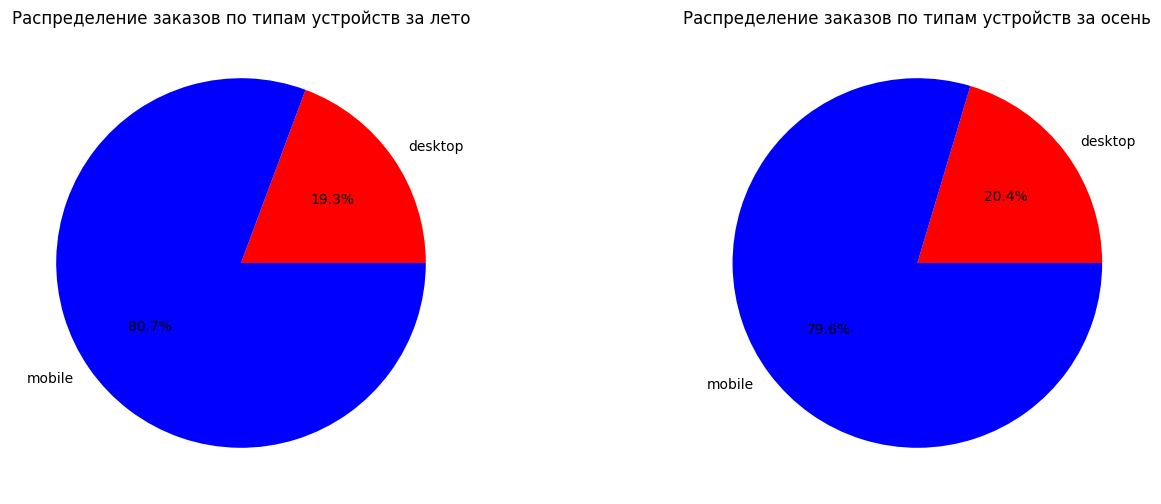

In [93]:
season_device_summer = new_df_cleaned[new_df_cleaned['season'] == 'лето'].groupby('device_type_canonical')['order_id'].count()
plt.figure(figsize=(16, 6))
#Диаграмма для летнего периода
plt.subplot(1, 2, 1)
season_device_summer.plot(
    kind='pie' ,
    title='Распределение заказов по типам устройств за лето',
    autopct='%.1f%%',
    ylabel='' ,
    colors=['red', 'blue', 'green', 'orange']
)
season_device_autumn = new_df_cleaned[new_df_cleaned['season'] == 'осень'].groupby('device_type_canonical')['order_id'].count()
#Диаграмма для осеннего периода
plt.subplot(1, 2, 2)
season_device_autumn.plot(
    kind='pie' ,
    title='Распределение заказов по типам устройств за осень',
    autopct='%.1f%%',
    ylabel='' ,
    colors=['red', 'blue']
)
plt.show()

По графику видно, что сезонность никак не влияет с какого типа устройства был приобретен билет.

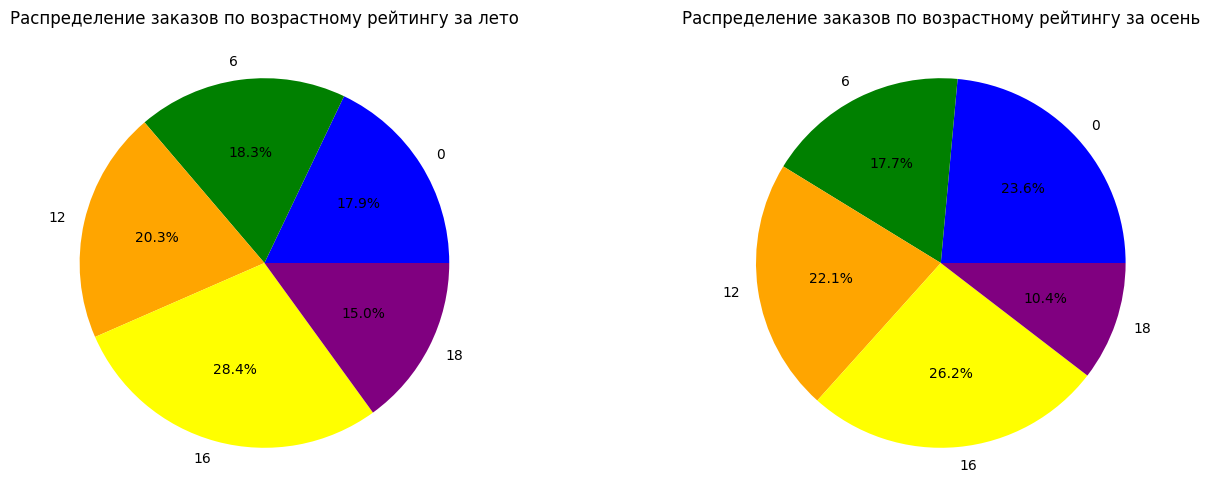

In [101]:
season_age_summer = new_df_cleaned[new_df_cleaned['season'] == 'лето'].groupby('age_limit')['order_id'].count()
plt.figure(figsize=(16, 6))
#Диаграмма для летнего периода
plt.subplot(1, 2, 1)
season_age_summer.plot(
    kind='pie' ,
    title='Распределение заказов по возрастному рейтингу за лето',
    autopct='%.1f%%',
    ylabel='' ,
    colors=['blue', 'green', 'orange', 'yellow', 'purple']
)
season_age_autumn = new_df_cleaned[new_df_cleaned['season'] == 'осень'].groupby('age_limit')['order_id'].count()
#Диаграмма для осеннего периода
plt.subplot(1, 2, 2)
season_age_autumn.plot(
    kind='pie' ,
    title='Распределение заказов по возрастному рейтингу за осень',
    autopct='%.1f%%',
    ylabel='' ,
    colors=['blue', 'green', 'orange', 'yellow', 'purple']
)
plt.show()

Сезонность на возрастные рейтинги практически не влияет. Больше стали покупать билетов осенью на ограничения 0+, возможно это детские мероприятия в связи с началом учебного года, но меньше 18+.

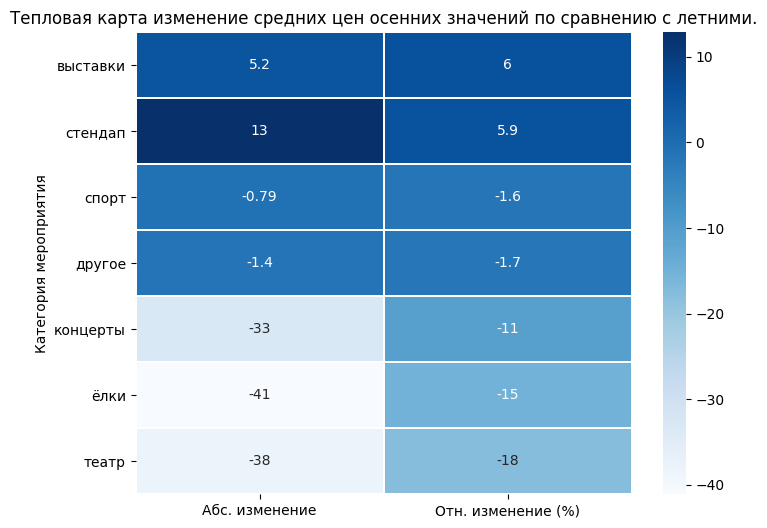

In [104]:
season_cost_per_ticket_summer = new_df_cleaned[new_df_cleaned['season'] == 'лето'].groupby('event_type_main')['one_ticket_revenue_rub'].mean()
season_cost_per_ticket_autumn = new_df_cleaned[new_df_cleaned['season'] == 'осень'].groupby('event_type_main')['one_ticket_revenue_rub'].mean()
diff_absolute = season_cost_per_ticket_autumn - season_cost_per_ticket_summer
diff_relative = ((season_cost_per_ticket_autumn - season_cost_per_ticket_summer) / season_cost_per_ticket_summer) * 100


price_between_season = pd.DataFrame({
    'Абс. изменение': round(diff_absolute, 2),
    'Отн. изменение (%)': round(diff_relative, 2)}).sort_values('Отн. изменение (%)', ascending=False)

plt.figure(figsize=(8, 6))
sns.heatmap(data = price_between_season, annot = True, linewidths=0.5, cmap = 'Blues')
plt.title ('Тепловая карта изменение средних цен осенних значений по сравнению с летними.')
plt.ylabel('Категория мероприятия')
plt.show()

Осенью выросли средние значения выручки за билет у таких категорий мероприятий как стендам и выставки.

 #### 3.2. Осенняя активность пользователей

Изучим активность пользователей за два месяца осени.

In [110]:
df_autumn = new_df_cleaned[(new_df_cleaned['season'] == 'осень')].copy()
daily_stats = df_autumn.groupby(df_autumn['created_dt_msk'].dt.date).agg(total_orders=('order_id', 'count'), dau =('user_id', 'nunique'), avg_ticket_price=('one_ticket_revenue_rub', 'mean')).reset_index()
daily_stats['orders_per_user'] = daily_stats['total_orders'] / daily_stats['dau']
daily_stats     

,created_dt_msk,total_orders,dau,avg_ticket_price,orders_per_user
0,2024-09-01,1331,565,201.678176,2.355752
1,2024-09-02,1376,573,190.015637,2.401396
2,2024-09-03,5095,777,80.802794,6.557272
3,2024-09-04,1761,684,179.630227,2.574561
4,2024-09-05,1942,739,190.040733,2.627876
...,...,...,...,...,...
56,2024-10-27,2849,1034,188.109793,2.755319
57,2024-10-28,2840,985,171.174806,2.883249
58,2024-10-29,2838,999,178.586734,2.840841
59,2024-10-30,2928,1040,183.350243,2.815385


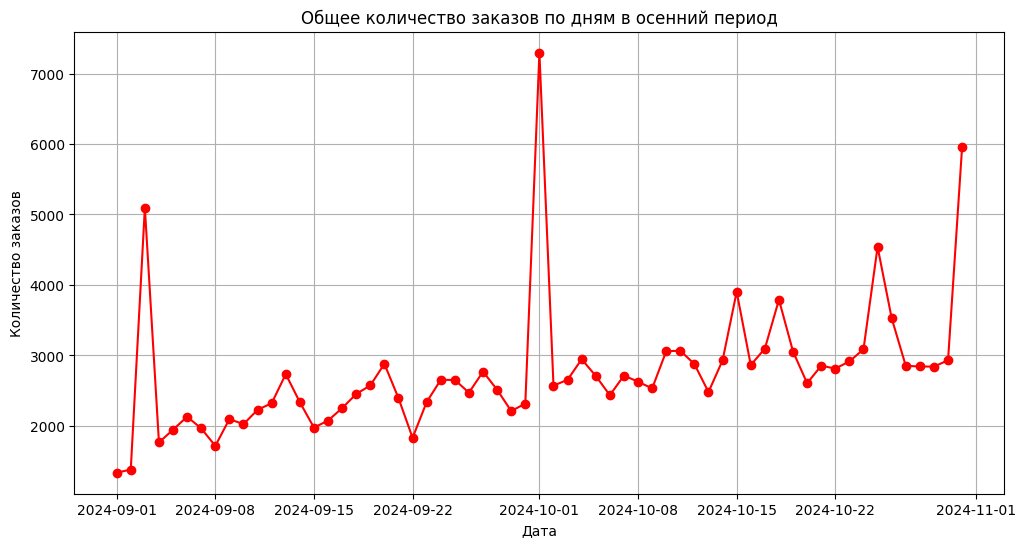

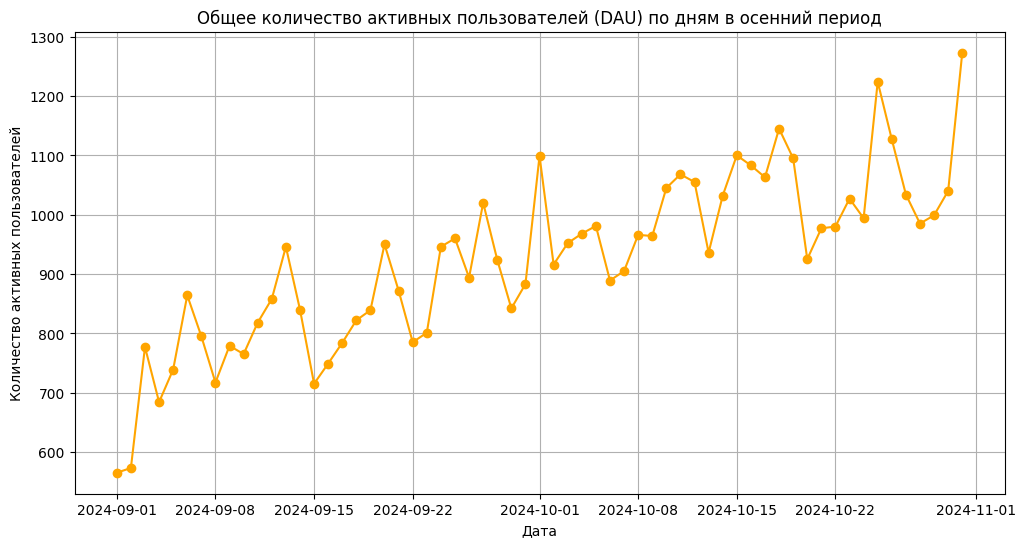

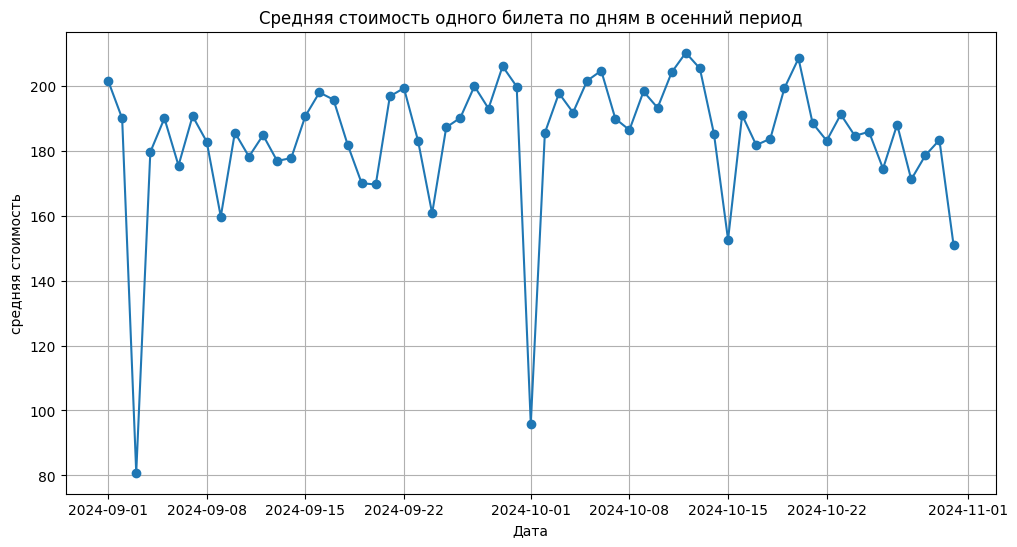

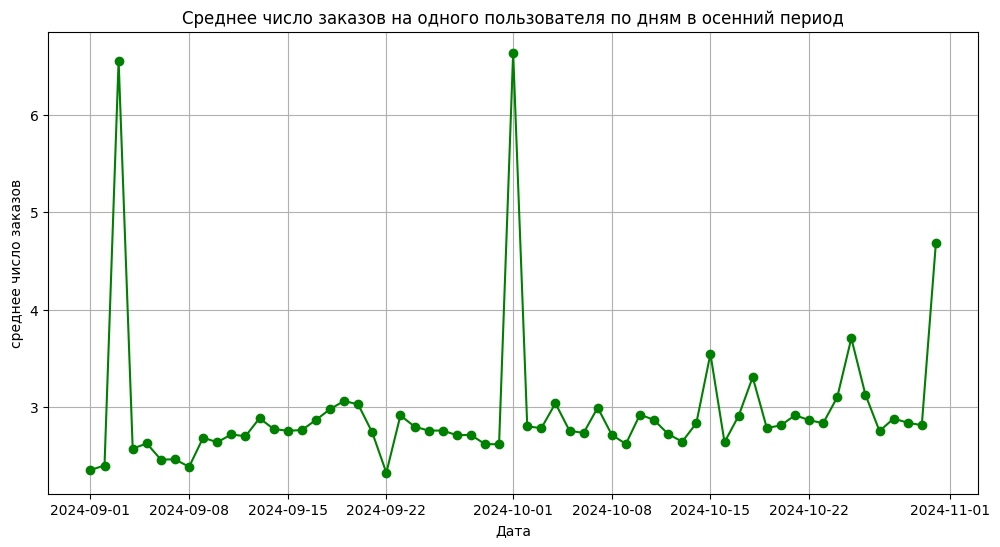

In [112]:
#Построим график общее количество заказов по дням в осенний период
plt.figure(figsize=(12, 6))
plt.plot(daily_stats['created_dt_msk'], daily_stats['total_orders'], marker = 'o', color = 'red')
plt.title('Общее количество заказов по дням в осенний период')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.grid()
plt.show()

#Построим график количество активных пользователей по дням в осенний период
plt.figure(figsize=(12, 6))
plt.plot(daily_stats['created_dt_msk'], daily_stats['dau'], marker = 'o', color = 'orange')
plt.title('Общее количество активных пользователей (DAU) по дням в осенний период')
plt.xlabel('Дата')
plt.ylabel('Количество активных пользователей')
plt.grid()
plt.show()

#Построим график средней стоимости одного билета по дням в осенний период
plt.figure(figsize=(12, 6))
plt.plot(daily_stats['created_dt_msk'], daily_stats['avg_ticket_price'], marker = 'o')
plt.title('Средняя стоимость одного билета по дням в осенний период')
plt.xlabel('Дата')
plt.ylabel('средняя стоимость')
plt.grid()
plt.show()

#Построим график среднее число заказов на одного пользователя по дням в осенний период
plt.figure(figsize=(12, 6))
plt.plot(daily_stats['created_dt_msk'], daily_stats['orders_per_user'], marker = 'o', color = 'green')
plt.title('Среднее число заказов на одного пользователя по дням в осенний период')
plt.xlabel('Дата')
plt.ylabel('среднее число заказов')
plt.grid()
plt.show()

По графику видно, что общее количество заказов во второй и последний день сентября резко увеличилось, также скачок был в конце октябре.

Количество активных пользователей показывает равномерный рост. 

В те дни, когда средняя стоимость билета падала, среднее число заказов на пользователя росло.

Далее изучим недельную цикличность и сравним пользовательскую активность в будни и выходные.

In [116]:
df_week = df_autumn.copy()
#Создадим столбец с нумерацией дня недели
df_week['day_of_week']=df_week['created_dt_msk'].dt.dayofweek
#Разделим будни/выходные
df_week['is_weekend'] = df_week['created_dt_msk'].dt.dayofweek >= 5 
df_week['day_name'] = df_week['created_dt_msk'].dt.day_name()
weekend_stats = df_week.groupby(['day_of_week', 'day_name', 'is_weekend']).agg(
    total_orders=('order_id', 'count'),
    dau=('user_id', 'nunique'),
    avg_ticket_price=('one_ticket_revenue_rub', 'mean')).reset_index()
weekend_stats

,day_of_week,day_name,is_weekend,total_orders,dau,avg_ticket_price
0,0,Monday,False,21517,4447,184.798976
1,1,Tuesday,False,31483,4797,141.617805
2,2,Wednesday,False,22880,4817,186.723514
3,3,Thursday,False,27147,4968,178.718731
4,4,Friday,False,24835,4871,186.321164
5,5,Saturday,True,21349,4570,192.818479
6,6,Sunday,True,19409,4397,198.951741


Построим график и сравним активность пользователей в будни и выходные.

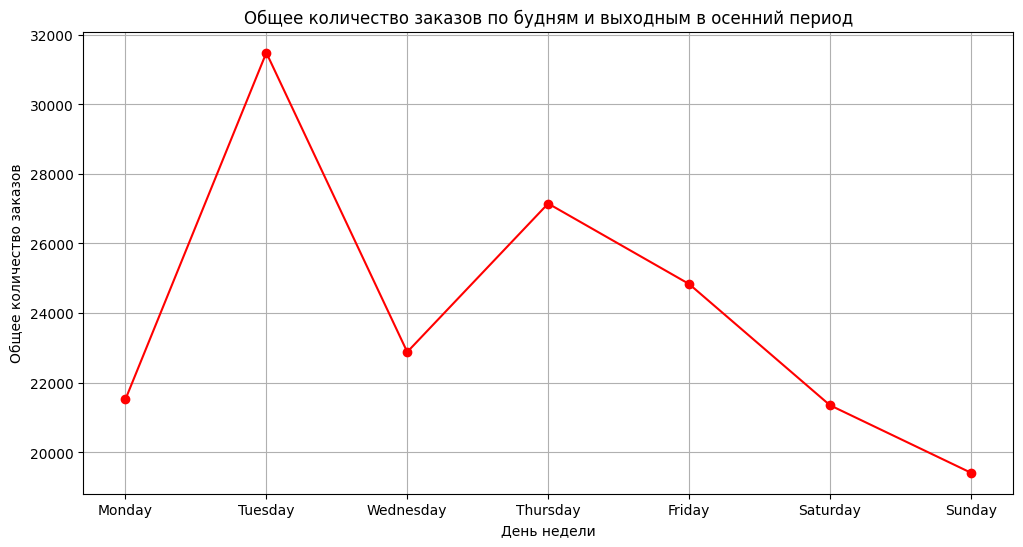

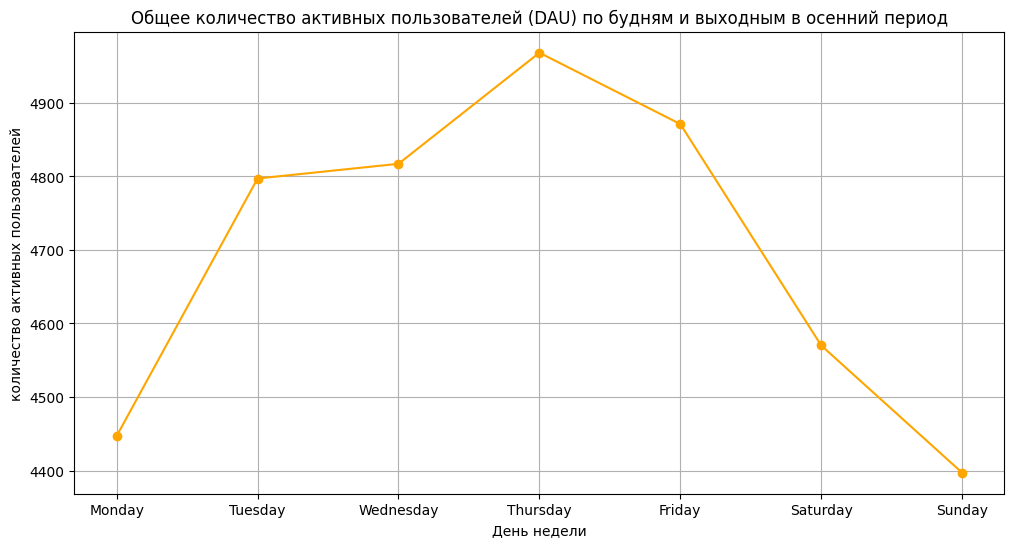

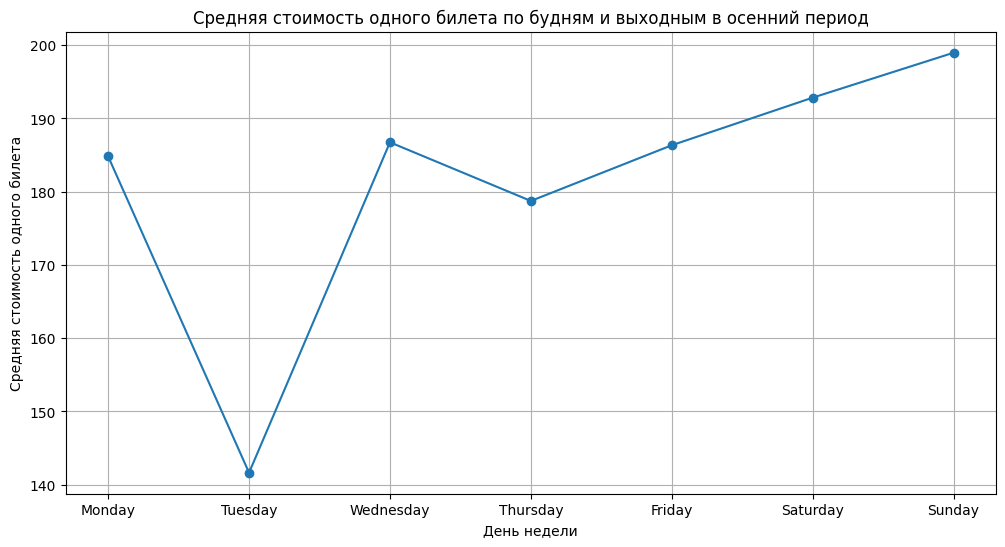

In [119]:
#Построим график общее количество заказов по будням и выходным в осенний период
plt.figure(figsize=(12, 6))
plt.plot(weekend_stats['day_name'], weekend_stats['total_orders'], marker = 'o', color = 'red')
plt.title('Общее количество заказов по будням и выходным в осенний период')
plt.xlabel('День недели')
plt.ylabel('Общее количество заказов')
plt.grid()
plt.show()

#Построим график общее количество активных пользователей (DAU) по будням и выходным в осенний период
plt.figure(figsize=(12, 6))
plt.plot(weekend_stats['day_name'], weekend_stats['dau'], marker = 'o', color = 'orange')
plt.title('Общее количество активных пользователей (DAU) по будням и выходным в осенний период')
plt.xlabel('День недели')
plt.ylabel('количество активных пользователей')
plt.grid()
plt.show()

#Построим график средняя стоимость одного билета по будням и выходным в осенний период
plt.figure(figsize=(12, 6))
plt.plot(weekend_stats['day_name'], weekend_stats['avg_ticket_price'], marker = 'o')
plt.title('Средняя стоимость одного билета по будням и выходным в осенний период')
plt.xlabel('День недели')
plt.ylabel('Средняя стоимость одного билета')
plt.grid()
plt.show()

В будни количество заказов, уникальных пользователей больше, но в выходрные средняя стоимость билета выше. Интересный факт, что по вторникам увеличивается число заказов, а средняя стоимость билета падает, а в среду, когда количество заказов падает, то средняя стоимость билета увеличивается.

####  3.3. Популярные события и партнёры

Посмотрим, как события распределены по регионам и партнёрам.

In [124]:
# посчитаем уникальное количество мероприятий и общее число заказов.
region_stats = df_autumn.groupby('region_name').agg(count_events=('event_id', 'nunique'), total_orders=('order_id', 'count')).sort_values('total_orders', ascending=False).reset_index()

In [126]:
total_events = region_stats['count_events'].sum()
total_orders_all = region_stats['total_orders'].sum()

region_stats['events_share'] = round(region_stats['count_events'] / total_events * 100, 2)
region_stats['orders_share'] = round(region_stats['total_orders'] / total_orders_all * 100, 2)

# Выведем ТОП-7 регионов 
region_stats.head(7)

,region_name,count_events,total_orders,events_share,orders_share
0,Каменевский регион,3914,46723,24.70,27.71
1,Североярская область,2611,20712,16.48,12.28
2,Медовская область,368,12044,2.32,7.14
3,Широковская область,796,8648,5.02,5.13
4,Озернинский край,296,7526,1.87,4.46
5,Светополянский округ,762,4771,4.81,2.83
6,Малиновоярский округ,137,4546,0.86,2.70


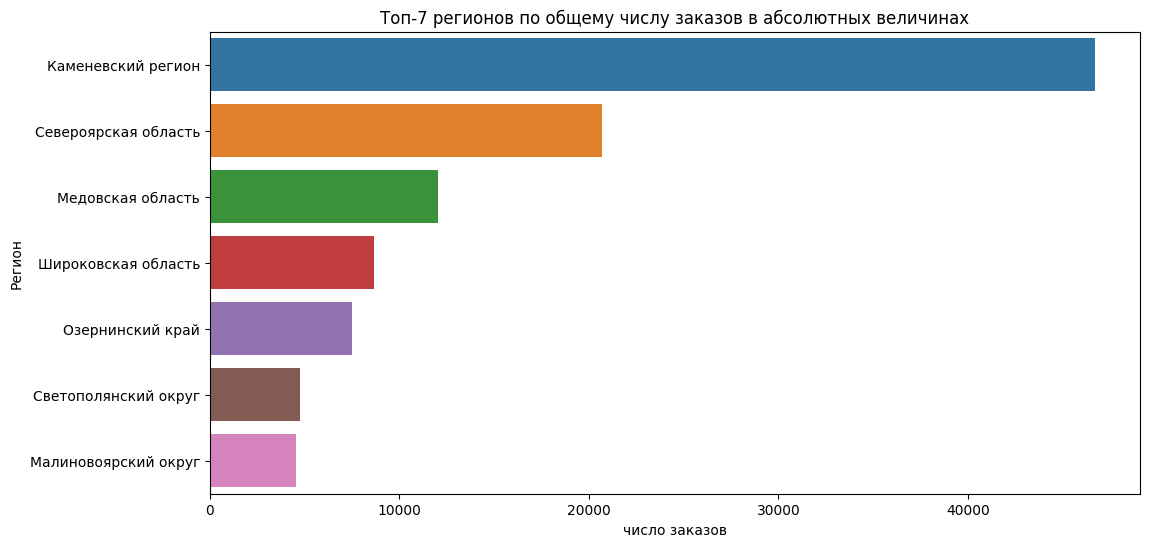

In [128]:
# Визуализируем топ-7 регионов по общему числу заказов в абсолютных величинах
plt.figure(figsize=(12, 6))
top_regions = region_stats.head(7).sort_values('total_orders', ascending = False)
sns.barplot(data=top_regions, y='region_name', x='total_orders')
plt.title('Топ-7 регионов по общему числу заказов в абсолютных величинах')
plt.xlabel('число заказов')
plt.ylabel('Регион')
plt.show()

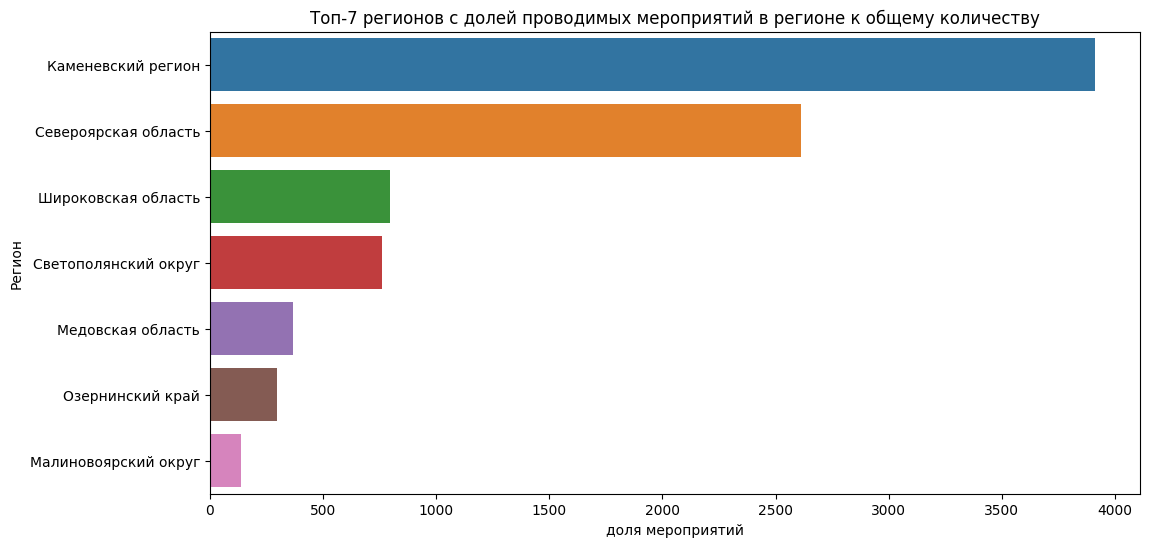

In [133]:
# Визуализируем топ-7 регионов с долей проводимых мероприятий в регионе от общего количества
plt.figure(figsize=(12, 6))
top_regions = region_stats.head(7).sort_values('count_events', ascending = False)
sns.barplot(data=top_regions, y='region_name', x='count_events')
plt.title('Топ-7 регионов с долей проводимых мероприятий в регионе к общему количеству')
plt.xlabel('доля мероприятий')
plt.ylabel('Регион');

В Каменевский регионе, Североярской области наибольшее разнообразие мероприятий. Топ области по количеству заказов эти же  регионы: Каменевский регион и Североярская область.

In [136]:
partner_top = df_autumn.groupby('service_name').agg(count_events=('event_id', 'nunique'), total_orders=('order_id', 'count'), total_revenue=('revenue_rub', 'sum')).sort_values('total_revenue', ascending=False).reset_index()

total_events = partner_top['count_events'].sum()
total_orders_all = partner_top['total_orders'].sum()
total_revenue_all = partner_top['total_revenue'].sum()

partner_top['events_share'] = round(partner_top['count_events'] / total_events * 100, 2)
partner_top['orders_share'] = round(partner_top['total_orders'] / total_orders_all * 100, 2)
partner_top['revenue_share'] = round(partner_top['total_revenue'] / total_revenue_all * 100, 2)

# Выведем ТОП-7 регионов 
partner_top.head(7)

,service_name,count_events,total_orders,total_revenue,events_share,orders_share,revenue_share
0,Билеты без проблем,2837,32464,1.252536e+07,16.43,19.25,15.20
1,Мой билет,1005,19421,1.085873e+07,5.82,11.52,13.18
2,Облачко,1409,15478,1.061105e+07,8.16,9.18,12.88
3,Лови билет!,3613,25784,1.041309e+07,20.93,15.29,12.64
4,Весь в билетах,600,9427,9.379749e+06,3.48,5.59,11.38
5,Билеты в руки,2457,25649,7.621682e+06,14.23,15.21,9.25
6,Край билетов,193,3005,3.039285e+06,1.12,1.78,3.69


<Figure size 1600x800 with 0 Axes>

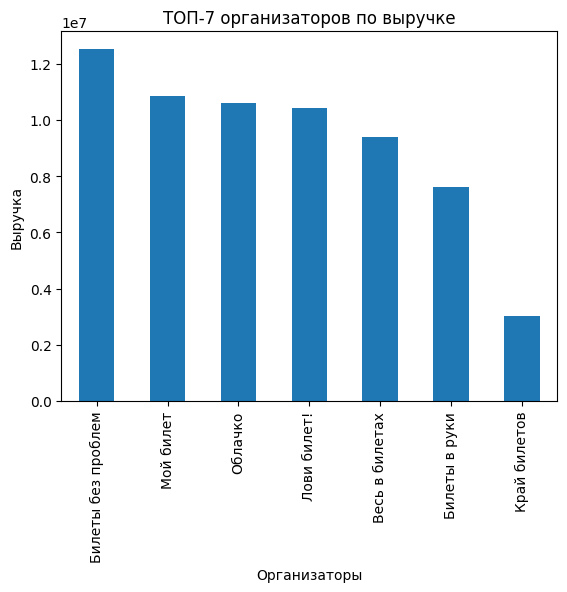

In [138]:
plt.figure(figsize=(16, 8))
df_autumn.groupby('service_name').agg({'revenue_rub':'sum'}).sort_values(by = 'revenue_rub', ascending = False).head(7).plot(
               kind='bar', 
               rot=90,
               legend=False,
               title=f'ТОП-7 организаторов по выручке'
)

# Настраиваем оформление графика
plt.xlabel('Организаторы')
plt.ylabel('Выручка')
plt.show()

Есть явные лидеры по выручке среди партнеров. Это Билеты без проблем, Мой билет, Облачко, Лови билет.

<Figure size 1800x1200 with 0 Axes>

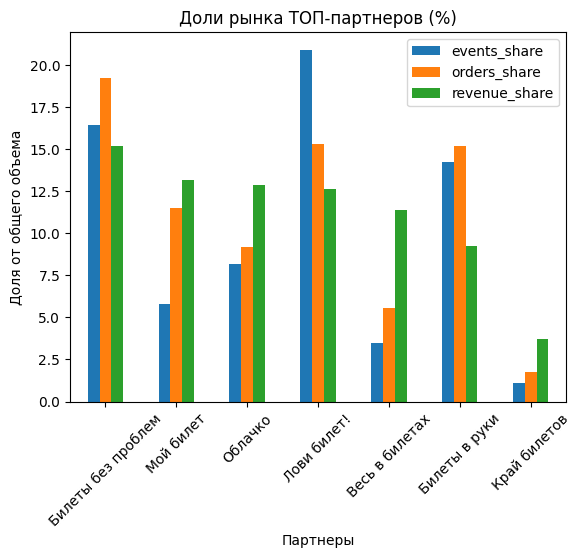

In [141]:
#Топ-7 Распределение по долям рынка
plt.figure(figsize=(18, 12))
partner_top.head(7).set_index('service_name')[['events_share', 'orders_share', 'revenue_share']].plot(
    kind='bar') 
plt.title('Доли рынка ТОП-партнеров (%)')
plt.ylabel('Доля от общего объема')
plt.xlabel('Партнеры')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()

По количеству мероприятий лидирует Лови билет, по количеству заказов Билеты без проблем.

### 4. Статистический анализ данных

Проверим две гипотезы: 
- Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.
- Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

Первая гипотеза звучит так: Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств. Попробуем статистически это доказать.

- Нулевая гипотеза H₀:  Среднее количество заказов на одного пользователя в мобильном приложении не выше, чем на стационарном устройстве.

- Альтернативная гипотеза H₁: Среднее количество заказов на одного пользователя в мобильном приложении выше, и это различие статистически значимо.

In [149]:
#проверим, есть ли пользователи, которые попали в обе группы
mobile_user = df_autumn[df_autumn['device_type_canonical'] == 'mobile']['user_id']
desktop_user = df_autumn[df_autumn['device_type_canonical'] == 'desktop']['user_id']

intersection = list(set(mobile_user) & set(desktop_user))
print(intersection)

['f60b9fb57caf00f', 'cc5bd8bc1197b50', '8cb186425673c85', 'f271b7f7324f94e', '694442efd216a70', '3cc0f06d17718f3', 'fd127030c0df686', '75ee40712f02695', '9dda32803cb7680', '04b6911607ebb3e', '6c259a4169ed197', 'f98a542063923fb', '4e2392b13d298b4', 'faeb88addaf0c79', 'ec2bc5a62c0c832', '355de7158726ec6', '53db8dad29242cc', '8b74c281674a2ff', '8f58dd17b4270b4', '6feccdb2d109909', '18cdac946ea6e01', '40a212c6f2a4217', '78d24e7240c8149', 'dba80368a42e538', '67d2fd27db32bc9', '1a41b965d239551', '3709bb304ee3774', '394c8b77e605b58', '464336a26eaf304', '58439e24a4ad5c9', '9147ecaf2801bf5', '9e5727fbd2b63dd', '23b021c21d4f7d5', 'e26e26c770d0b1b', 'fa2dbe07a6f3854', '29424169530f6d0', '88b725d613a0bda', '6bf0c4152af5e43', '979b3c40066ca06', '73d0700735ef939', '5d4abed0f5fb0b6', 'ae8e3d5af3036a6', '7e58e16f7a514f4', 'fe6a68c787f5b5d', '60d09a82e783d09', 'a5dac5d0538d62d', 'fb742c77c5986fa', 'a6efcf6b0977770', 'fb0de52c0155400', '39d95f0399cb7b7', '0f297636fceff2d', '39f45ffb7750015', '756d1d58f1

Пересечения есть, удалим таких пользователей, выборки будут независимые.

In [152]:
# Проверим, остались ли пересечения
clean_df_autumn = df_autumn[~df_autumn['user_id'].isin(intersection)]
mobile_clean = clean_df_autumn[clean_df_autumn['device_type_canonical'] == 'mobile']['user_id']
desktop_clean = clean_df_autumn[clean_df_autumn['device_type_canonical'] == 'desktop']['user_id']
intersection_clean = list(set(mobile_clean) & set(desktop_clean))
intersection_clean

[]

In [155]:
# Группировка по устройству
order_per_user = clean_df_autumn.groupby('device_type_canonical').agg(unique_users=('user_id', 'nunique'), total_orders=('order_id', 'count')).reset_index()
# Расчет среднего по группам
order_per_user['avg_orders'] = round(order_per_user['total_orders'] / order_per_user['unique_users'], 2)                                                                       
order_per_user


,device_type_canonical,unique_users,total_orders,avg_orders
0,desktop,1623,3193,1.97
1,mobile,10940,31272,2.86


In [157]:
#Посмотрим разницу средних между устройствами
mobile_avg = order_per_user[order_per_user['device_type_canonical'] == 'mobile']['avg_orders'].values[0]
desktop_avg = order_per_user[order_per_user['device_type_canonical'] == 'desktop']['avg_orders'].values[0]

difference = mobile_avg - desktop_avg

print(f" Разница средних между мобильными и десктопными устройствами: {round(difference, 2)} заказов на пользователя")

 Разница средних между мобильными и десктопными устройствами: 0.89 заказов на пользователя


По расчетам, в мобильном приложении пользователи в среднем покупают больше билетов. 


Данные о количестве заказов обычно имеют скошенность, нет предположения о нормальности распределения. Выберем тест Манна-Уитни. Этот тест устойчик к выбросам, так как рассматривает ранги наблюдений, отказываясь от значений в каждой выборке. Он ориентируется лишь на характер распределения: асимметрию и скошенность. То есть он нечувствителен к выбросам из-за рангового преобразования. Используем его.

In [161]:
# Проверяем гипотезу

alpha = 0.05 
stat_mw, p_value_mw = mannwhitneyu(
    mobile_avg, 
    desktop_avg, 
    alternative='greater' 
) 

if p_value_mw > alpha:
    print(f'pvalue={p_value_mw} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
    print('Интерпретация: Среднее количество заказов на одного пользователя в мобильном приложении не выше, чем на стационарном устройстве.')
else:
    print(f'pvalue={p_value_mw} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')
    print('Интерпретация: Среднее количество заказов на одного пользователя в мобильном приложении выше, и это различие статистически значимо.')


pvalue=0.5 > 0.05
Нулевая гипотеза находит подтверждение!
Интерпретация: Среднее количество заказов на одного пользователя в мобильном приложении не выше, чем на стационарном устройстве.


Различия были статистически незначимы.

Вторая гипотеза звучит так: Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств. Попробуем статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀:  Среднее время между заказами пользователей  в мобильном приложении не выше, чем на стационарнои устройстве.

- Альтернативная гипотеза H₁: Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

In [165]:
# Разделим на группы по типу устройств
mobile_times = clean_df_autumn[clean_df_autumn['device_type_canonical'] == 'mobile']['days_since_prev'].dropna()
desktop_times = clean_df_autumn[clean_df_autumn['device_type_canonical'] == 'desktop']['days_since_prev'].dropna()

print("Мобильные пользователи:")
print(mobile_times.describe())
print("\nСтационарные пользователи:")
print(desktop_times.describe())


Мобильные пользователи:
count    24586.000000
mean        13.790735
std         25.716296
min          0.000000
25%          0.000000
50%          1.000000
75%         15.000000
max        148.000000
Name: days_since_prev, dtype: float64

Стационарные пользователи:
count    2070.000000
mean       18.165217
std        32.743253
min         0.000000
25%         0.000000
50%         0.000000
75%        23.000000
max       146.000000
Name: days_since_prev, dtype: float64


In [167]:
mobile_mean = mobile_times.mean()
desktop_mean = desktop_times.mean()

difference_time = mobile_mean - desktop_mean
print(f" Разница среднего времени между заказами через мобильные и десктопные устройства: {round(difference_time)} дня")

 Разница среднего времени между заказами через мобильные и десктопные устройства: -4 дня


Выбираем снова статистический тест Манна-Уитни, так как в данных есть скошенность, также различается разброс значений в группах (std). Среднее значение отличается от медианы, значит есть выбросы.

In [170]:
# установим уровень значимости.
alpha = 0.05 

stat_mw, p_value_mw = mannwhitneyu(
    mobile_times, 
    desktop_times, 
    alternative='greater' 
) 

if p_value_mw > alpha:
    print(f'pvalue= {p_value_mw} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
    print('Интерпретация: Среднее время между заказами пользователей  в мобильном приложении не выше, чем на стационарнои устройстве.')
else:
    print(f'pvalue= {p_value_mw} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')
    print('Интерпретация: Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.')


pvalue= 8.613226693679806e-08 < 0.05
Нулевая гипотеза не находит подтверждения!
Интерпретация: Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.


Различия статистически значимы, мы можем предполагать, что нулевая гипотеза не находит подтверждение. У пользователей с мобильных устройств среднее время между заказами выше по сравнению с пользователями стационарных устройств.

### Общий вывод и рекомендации.

В нашем распоряжении были данные о бронировании билетов на сервисе Яндекс Афиша за период с 1 июня по 30 октября 2024 года.

В данных были выбросы, поэтому мы отфильтровали их по 0.01 и 0.99 перцентелю, удалили дубликаты, преобразовали типы данных, снизили их размерность. 

Создали несколько новых столбцов: revenue_rub - привели выручку к однорй валюте - российскому рублю, one_ticket_revenue_rub - рассчитали выручку с продажи одного билета на мероприятие, month - выделили месяц оформления заказа, season - создали столбец с информацией о сезонности.

После исследовательского анализа можно сделать следующие выводы:
- Летом наиболее популярны такие мероприятия как: концерты 42.7%, другие мероприятия 27.2%, театры 20.0%
- Осенью популярны такие же мероприятия: концерты 38.9%, театры 25.7%, другие мероприятия 20.6%. 
-Осенью выросли средние значения выручки за билет у таких категорий мероприятий как стендап(рост 6.2%) и выставки(рост 5.3%).
- Пользовательская активность от летнего периода к осеннему росла, было два скачка в осенних месяцах, когда средняя стоимость билета падала а среднее число заказов на пользователя росло.
- В будни количество заказов, уникальных пользователей больше, но в выходрные средняя стоимость билета выше.
- Также существует среди регионов явные лидеры по числу заказов это Каменевский регион и Североярская область.
- Среди партнеров по выручке с продажи билетов также есть лидеры - это Билеты без проблем, Мой билет, Облачко, Лови билет.

Также были проверены две гипотезы. Первая гипотеза не нашла подтверждение, поэтому среднее количество заказов на одного пользователя в двух группах (мобильное приложение и стационарное устройство) не различается. Во второй нулевая гипотеза не нашла подтверждение, поэтому мы предполагаем, у пользователей с мобильных устройств среднее время между заказами выше по сравнению с пользователями стационарных устройств.

Данные рассмотрены за летний период, когда многие уезжают в отпуска и два месяца осени, когда начинается театральные сезоны и спортивные турниры, поэтому данные стоит рассмотреть и в другом временном разрезе.

Есть рекомендации по дальнейшей работе сервиса - это продвижение в регионах с низкими показателями, поиск новых партнеров и постоянный мониторинг конкурентов (их акции, интересные предложения, уникальные мероприятия).